In [ ]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings

warnings.filterwarnings("ignore")

In [ ]:
os.listdir('./dataa/')


['down', 'go', 'left', 'stop', 'up', 'yes']

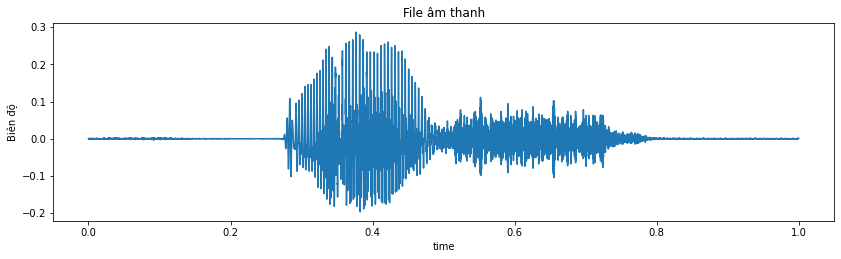

In [ ]:
train_audio_path = './dataa/'
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('File âm thanh')
ax1.set_xlabel('time')
ax1.set_ylabel('Biên độ')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

tốc độ lấy mẫu của 1 bản ghi hiện tại

In [ ]:
ipd.Audio(samples, rate=sample_rate)

In [ ]:
print(sample_rate)

16000


tên lables

In [ ]:
labels=os.listdir(train_audio_path)
print(labels)

['down', 'go', 'left', 'stop', 'up', 'yes']


số lượng bản ghi âm thanh trong từ lables

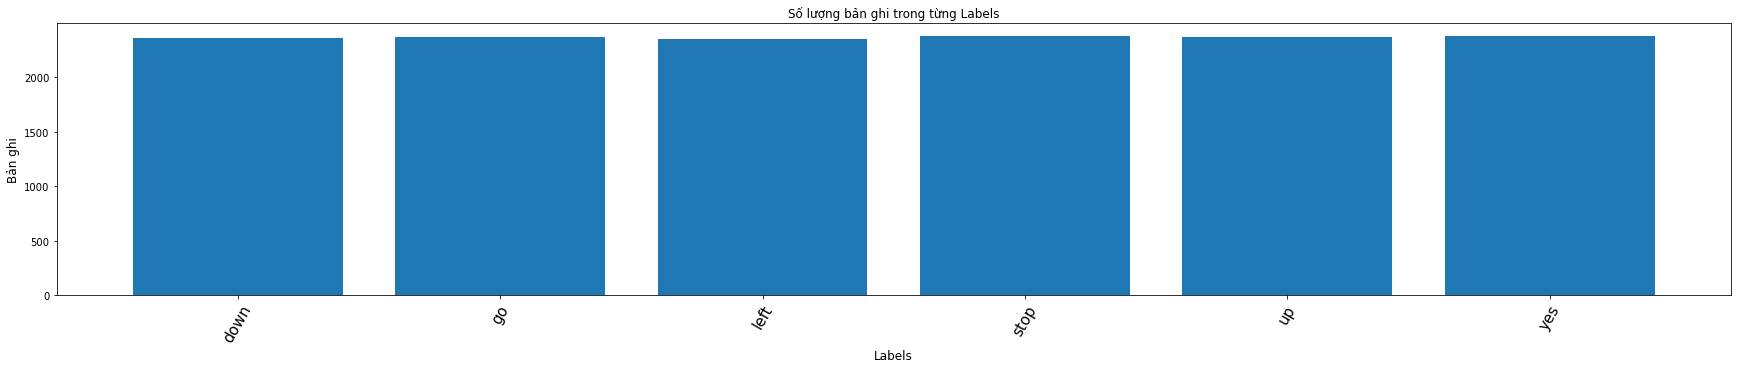

In [ ]:
ban_ghi=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    ban_ghi.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, ban_ghi)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Bản ghi', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('Số lượng bản ghi trong từng Labels')

plt.show()

Lấy labels tùy thuộc vào thư mục các bạn lấy


In [ ]:
labels=['down', 'go', 'left', 'stop', 'up', 'yes']
print(len(labels))

6


# xử lý âm thanh từ 16000hz xuống thành 8000hz

In [ ]:
train_audio_path = './dataa/'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

down
go
left
stop
up
yes


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

biểu diễn nhãn dưới dạng 1 vector, do đầu ra của soft-max là dạng vector ko nhận số nguyên .

In [ ]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))
print(y)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


chuyển bản ghi từ 2D thành 3D

In [ ]:
all_wave = np.array(all_wave).reshape(-1,8000,1)
print(all_wave)

[[[-1.27418665e-04]
  [-1.12644804e-04]
  [-1.86756923e-04]
  ...
  [-1.62762426e-05]
  [-4.93293861e-04]
  [-3.55132594e-04]]

 [[-3.06998868e-03]
  [-4.10807552e-03]
  [-3.31036211e-03]
  ...
  [-4.67803935e-03]
  [-4.21488844e-03]
  [-6.10053446e-03]]

 [[ 1.59116389e-04]
  [ 1.11387717e-03]
  [-1.25855627e-03]
  ...
  [-9.50679742e-03]
  [ 1.47810066e-02]
  [ 3.41885872e-02]]

 ...

 [[-1.85306981e-05]
  [-1.71164083e-05]
  [-1.54497160e-04]
  ...
  [ 2.06036333e-04]
  [ 1.48386171e-04]
  [ 3.01423628e-04]]

 [[-1.30340501e-04]
  [-2.39358909e-04]
  [-3.63490370e-04]
  ...
  [ 5.96821948e-04]
  [ 4.44039761e-04]
  [ 3.38887010e-04]]

 [[ 3.70314316e-04]
  [ 7.60705036e-04]
  [ 7.26655941e-04]
  ...
  [-7.63626129e-04]
  [-8.35912302e-04]
  [-5.12795756e-04]]]


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))
# conv1D tích chập 1 chiều (mảng 1 chiều)

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv) # làm phẳng dữ liệu ra

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv) # tránh các nút mạng trong lớp quá phụ thuộc lẫn nhau trong quá trình huấn luyện (tránh việc học tủ)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2662, 8)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2652, 16)          1424      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 884, 16)          0         
 1D)                                                         

thiết lập tham sô cho mô hình 

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) # dừng sớm mô hình đúng thời điểm
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') # lưu trữ mô hình qua mỗi vòng lặp

In [ ]:
history=model.fit(x_train, y_train ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/100
320/321 [============================>.] - ETA: 0s - loss: 1.5741 - accuracy: 0.3241
Epoch 00001: val_accuracy improved from -inf to 0.47561, saving model to best_model.h5
321/321 [==============================] - 43s 132ms/step - loss: 1.5743 - accuracy: 0.3243 - val_loss: 1.2698 - val_accuracy: 0.4756
Epoch 2/100
320/321 [============================>.] - ETA: 0s - loss: 1.1820 - accuracy: 0.5024
Epoch 00002: val_accuracy improved from 0.47561 to 0.59266, saving model to best_model.h5
321/321 [==============================] - 42s 130ms/step - loss: 1.1820 - accuracy: 0.5021 - val_loss: 1.0186 - val_accuracy: 0.5927
Epoch 3/100
320/321 [============================>.] - ETA: 0s - loss: 0.9897 - accuracy: 0.6063
Epoch 00003: val_accuracy improved from 0.59266 to 0.69411, saving model to best_model.h5
321/321 [==============================] - 35s 110ms/step - loss: 0.9898 - accuracy: 0.6065 - val_loss: 0.8465 - val_accuracy: 0.6941
Epoch 4/100
320/321 [===================

Epoch 28/100
320/321 [============================>.] - ETA: 0s - loss: 0.2198 - accuracy: 0.9188
Epoch 00028: val_accuracy did not improve from 0.86929
321/321 [==============================] - 36s 112ms/step - loss: 0.2203 - accuracy: 0.9186 - val_loss: 0.4314 - val_accuracy: 0.8576
Epoch 29/100
320/321 [============================>.] - ETA: 0s - loss: 0.2057 - accuracy: 0.9253
Epoch 00029: val_accuracy did not improve from 0.86929
321/321 [==============================] - 34s 107ms/step - loss: 0.2056 - accuracy: 0.9253 - val_loss: 0.4097 - val_accuracy: 0.8673
Epoch 30/100
320/321 [============================>.] - ETA: 0s - loss: 0.2249 - accuracy: 0.9177
Epoch 00030: val_accuracy improved from 0.86929 to 0.87437, saving model to best_model.h5
321/321 [==============================] - 35s 109ms/step - loss: 0.2248 - accuracy: 0.9177 - val_loss: 0.4040 - val_accuracy: 0.8744
Epoch 31/100
320/321 [============================>.] - ETA: 0s - loss: 0.2078 - accuracy: 0.9263
Epoch 

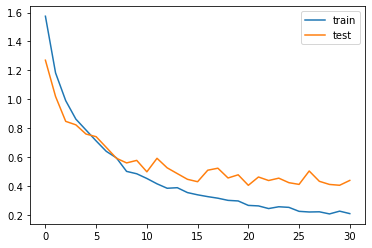

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
test_loss, test_acc = model.evaluate(x_val,y_val, verbose=2)

81/81 - 1s - loss: 0.4375 - accuracy: 0.8549 - 1s/epoch - 17ms/step


In [ ]:
print(test_acc)

0.8548575639724731


In [ ]:
#  loading model
# import joblib
from keras.models import load_model

model=load_model('C:\\Users\\thanh\\Documents\\HọcMáy\\NhanDangKhauLenh\\best_model.h5')
# model = joblib.load('best_model.h5')

UnicodeEncodeError: 'mbcs' codec can't encode characters in position 0--1: invalid character

In [ ]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [ ]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)


Audio: up


In [ ]:
print("Text:",predict(samples))

Text: up


In [ ]:
import sounddevice as sd
from scipy.io.wavfile import write

samplerate = 16000  
duration = 1 # seconds
filename = 'record.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
write(filename,samplerate,mydata)

start
end


In [ ]:
#reading the voice commands
test, test_rate = librosa.load('record.wav', sr = 16000)
test_sample = librosa.resample(test, test_rate, 8000)
print(test_sample.shape)
ipd.Audio(test_sample,rate=8000) 

(8000,)


In [ ]:
print("Text:",predict(samples))

Text: up
